<a href="https://colab.research.google.com/github/dujest/yolov5-workshop/blob/main/Deep_CNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount your drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import PyTorch

In [ ]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F

# image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# image display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!mkdir /content/drive/MyDrive/colab

In [ ]:
%cd /content/drive/MyDrive/colab

/content/drive/MyDrive/colab


# Download a dataset

In [ ]:
!mkdir "/content/drive/MyDrive/colab/corrosion_dataset"
!wget  "https://universe.roboflow.com/ds/LQgs4TYGAN?key=Q2icURdATO" -O "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip"
!unzip "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip" -d "/content/drive/MyDrive/colab/corrosion_dataset"
!rm -r "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip"

# Load the train and test set

The next preprocessing and augmentations steps were applied:
- Auto-Orient: Applied
- Resize: Stretch to 416x416
- Outputs per training example: 3
- Flip: Horizontal, Vertical
- 90° Rotate: Clockwise, Counter-Clockwise, Upside Down
- Saturation: Between -15% and +15%
- Brightness: Between -12% and +12%
- Exposure: Between -5% and +5%
- Blur: Up to 0.5px

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(320),           # transform the images into a PyTorch tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # most activation functions have their strongest gradients around x = 0,
                                                              # so centering our data there can speed learning

batch_size = 4

# pull the data from the drive
trainset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/colab/corrosion_dataset/train', transform=transform)

# pull instances of the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/colab/corrosion_dataset/valid', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ("Corrosion", "No corrosion")

# Batch visualization

In [ ]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 50)

# function for inline image display
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# extract a batch of 4 images
dataiter = iter(trainloader)
images, labels = dataiter.next()

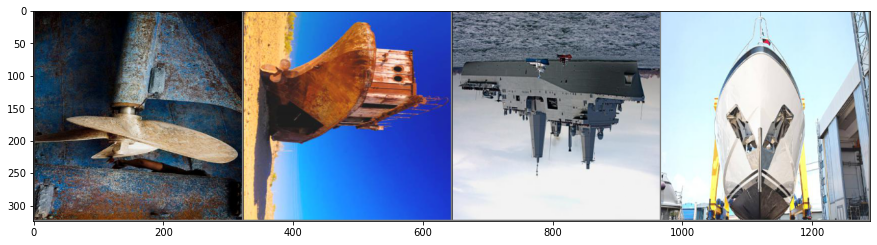

Corrosion 
Corrosion 
No corrosion
No corrosion


In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\n'.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))

# The CNN model

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, and so on.

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps), thanks to the convolutional layers.

At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction.

In [ ]:
conv1 = nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding='same').to(device)
pool = nn.MaxPool2d(2, 2).to(device)                                                   
conv2 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding='same').to(device)
conv3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding='same').to(device)
conv4 = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False).to(device)                 # the bottleneck's start
bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device)
conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding='same', bias=False).to(device)
conv6 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding='same').to(device) 
bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device) # the bottleneck's end
conv7 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding='same').to(device)
fc1 = nn.Linear(512 * 20 * 20, 120).to(device) # fully connected
fc2 = nn.Linear(120, 84).to(device)
fc3 = nn.Linear(84, 2).to(device)

print(f'Before Conv1:\n {images[0][0]}')

print(f'\nThe image size:{images.shape}')

images = images.to(device)
print(f'\nThe image is sent to {images.device}')

x = conv1(images)
print(f'\nAfter Conv1 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = conv2(x)
print(f'\nAfter Conv2 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = conv3(x)
print(f'\nAfter Conv3 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = F.relu(bn1(conv4(x)))
print(f'\nAfter Conv4, BatchNorm and ReLU the image size is: {x.shape}')

x = F.relu(bn1(conv5(x)))
print(f'\nAfter Conv5, ReLU and BatchNorm the image size is: {x.shape}')

x = F.relu(bn2(conv6(x)))
print(f'\nAfter Conv6, ReLU and BatchNorm the image size is: {x.shape}')

x = conv7(x)
print(f'\nAfter Conv7 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = torch.flatten(x, 1)
print(f'\nAfter flatten the image size is: {x.shape}')

x = fc1(x)
print(f'\nAfter fc1 the image size is: {x.shape}')

x = fc2(x)
print(f'\nAfter fc2 the image size is: {x.shape}')

x = fc3(x)
print(f'\nAfter fc3 the image size is: {x.shape}')

Before Conv1:
 tensor([[-0.4545,  0.0496,  0.2486,  ..., -0.1798, -0.1109, -0.1228],
        [-0.3886, -0.0159,  0.0945,  ..., -0.1782, -0.1188, -0.0710],
        [-0.3670, -0.1201, -0.0931,  ..., -0.1539, -0.1525, -0.0876],
        ...,
        [-0.6947, -0.6056, -0.3554,  ..., -0.0843, -0.0730, -0.0270],
        [-0.7090, -0.6935, -0.4684,  ..., -0.0989, -0.0836, -0.0354],
        [-0.7967, -0.5314, -0.2311,  ..., -0.0811, -0.1073, -0.0698]])

The image size:torch.Size([4, 3, 320, 320])

The image is sent to cuda:0

After Conv1 the image size is: torch.Size([4, 16, 320, 320])

After MaxPool the image size is: torch.Size([4, 16, 160, 160])

After Conv2 the image size is: torch.Size([4, 64, 160, 160])

After MaxPool the image size is: torch.Size([4, 64, 80, 80])

After Conv3 the image size is: torch.Size([4, 256, 80, 80])

After MaxPool the image size is: torch.Size([4, 256, 40, 40])

After Conv4, BatchNorm and ReLU the image size is: torch.Size([4, 64, 40, 40])

After Conv5, ReLU and 

**The purpose of the bottleneck layer is to capture patterns along the depth dimension, as it can not capture spatial patterns due to 1x1 kernel, and cut the computational cost by reducing the number of parameters or features maps.**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.conv3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.conv4 = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)                 # the bottleneck's start
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding='same', bias=False)
        self.conv6 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding='same') 
        self.bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) # the bottleneck's end
        self.conv7 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.fc1 = nn.Linear(512 * 20 * 20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn1((F.relu(self.conv4(x))))
        x = self.bn1((F.relu(self.conv5(x))))
        x = self.bn2((F.relu(self.conv6(x))))
        x = self.pool(F.relu(self.conv7(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)

# Optimizer and loss function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

# Train the CNN model

For each epoch, the for loop on each pass does the following:

- Gets a batch of training data from the DataLoader

- Zeros the optimizer’s gradients

- Performs an inference - that is, gets predictions from the model for an input batch

- Calculates the loss for that set of predictions vs. the labels on the dataset

- Calculates the backward gradients over the learning weights

- Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

- It reports on the loss for every epoch

In [ ]:
%%time

epochs = 40

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
          
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % len(trainloader) == len(trainloader)-1:
            print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}] => loss: {running_loss / len(trainloader):.3f}')

            if running_loss == 0.000:
                break


print('Finished Training')

[epoch: 1, batches:   155] => loss: 0.620
[epoch: 2, batches:   155] => loss: 0.532
[epoch: 3, batches:   155] => loss: 0.466
[epoch: 4, batches:   155] => loss: 0.423
[epoch: 5, batches:   155] => loss: 0.380
[epoch: 6, batches:   155] => loss: 0.472
[epoch: 7, batches:   155] => loss: 0.377
[epoch: 8, batches:   155] => loss: 0.332
[epoch: 9, batches:   155] => loss: 0.280
[epoch: 10, batches:   155] => loss: 0.354
[epoch: 11, batches:   155] => loss: 0.286
[epoch: 12, batches:   155] => loss: 0.276
[epoch: 13, batches:   155] => loss: 0.207
[epoch: 14, batches:   155] => loss: 0.239
[epoch: 15, batches:   155] => loss: 0.146
[epoch: 16, batches:   155] => loss: 0.135
[epoch: 17, batches:   155] => loss: 0.250
[epoch: 18, batches:   155] => loss: 0.143
[epoch: 19, batches:   155] => loss: 0.072
[epoch: 20, batches:   155] => loss: 0.091
[epoch: 21, batches:   155] => loss: 0.144
[epoch: 22, batches:   155] => loss: 0.073
[epoch: 23, batches:   155] => loss: 0.044
[epoch: 24, batches:

# Save and load the weights

In [ ]:
!mkdir ./weights

In [ ]:
PATH = './weights/corrosion.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Predictions

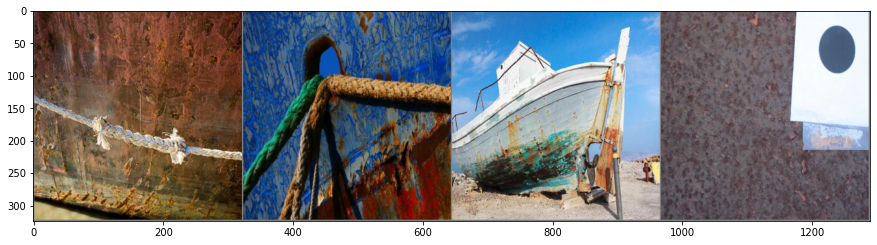

GroundTruth:
Corrosion
Corrosion
Corrosion
Corrosion


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:')
print('\n'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
images = images.to(device)
outputs = model(images)

In [ ]:
outputs

tensor([[ 1.1724, -2.0673],
        [-2.7093,  1.6187],
        [-0.6856,  0.5915],
        [-1.3824,  1.3600]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([1.1724, 1.6187, 0.5915, 1.3600], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([0, 1, 1, 1], device='cuda:0'))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted:')
print('\n'.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

Predicted:
Corrosion
No corrosion
No corrosion
No corrosion


# Accuracy

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)                    # Save Prediction
        y_true.extend(labels.data.cpu().numpy()) # Save Truth

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)*batch_size} test images: {100 * correct // total} %')

Accuracy of the network on the 60 test images: 83 %


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

df_cm

,Corrosion,No corrosion
Corrosion,38,7
No corrosion,3,12
